In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import StandardScaler

# === Load data ===
macro_path = 'data/Monthly Mastersheet with Original Data.xlsx'
crypto_lagged_path = 'data/All Exogenous Variables.xlsx'

df_macro = pd.read_excel(macro_path)
df_crypto_lagged = pd.read_excel(crypto_lagged_path)

# Format datetime
df_macro['Month'] = pd.to_datetime(df_macro['Month'])
df_macro.set_index('Month', inplace=True)
df_macro.index = pd.date_range(start=df_macro.index[0], periods=len(df_macro), freq='MS')

df_crypto_lagged['Month'] = pd.to_datetime(df_crypto_lagged['Month'])
df_crypto_lagged.set_index('Month', inplace=True)
df_crypto_lagged.index = pd.date_range(start=df_crypto_lagged.index[0], periods=len(df_crypto_lagged), freq='MS')

# Merge datasets
df = pd.merge(df_macro, df_crypto_lagged, left_index=True, right_index=True, how='inner')

# === Config ===
macro_vars = ['LFPR','CPI', 'r', 'M1', 'IM', 'EX', 'CC', 'GDP']
crypto_assets = ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin', 'Tether']
included_lags = range(4)  # 0–3
cutoff_date = pd.to_datetime('2024-01-01')

# fixed GARCH (1,1)

In [3]:
from itertools import combinations
from arch import arch_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from IPython.display import display, HTML

def safe_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100 if np.any(mask) else np.nan

def rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, l):
    history = list(y_train_scaled)
    preds = []
    last_model = None
    for t in range(len(y_test_scaled)):
        model = arch_model(history, mean='AR', lags=l, vol='GARCH', p=p, q=q, dist='normal', rescale=False)
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1, method='analytic')
        pred = forecast.mean.values[-1, 0]
        preds.append(pred)
        history.append(y_test_scaled[t])
        last_model = res
    return np.array(preds), last_model

def rolling_forecast_arx(y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, l):
    history_y = list(y_train_scaled)
    history_x = [x.reshape(1, -1) for x in x_train_scaled]
    preds = []
    models = []
    for t in range(len(y_test_scaled)):
        x_arr = np.vstack(history_x)
        model = arch_model(history_y, mean='ARX', lags=l, vol='GARCH', p=p, q=q, x=x_arr, dist='normal', rescale=False)
        res = model.fit(disp='off')
        const = res.params.get('Const', 0)
        phi = res.params.get('y[1]', 0)
        betas = np.array([res.params.get(f'x{i}', 0) for i in range(x_test_scaled.shape[1])])
        y_t = history_y[-1]
        x_t1 = np.asarray(x_test_scaled[t])
        pred = const + phi * y_t + np.dot(betas, x_t1)
        preds.append(pred)
        history_y.append(y_test_scaled[t])
        history_x.append(x_t1.reshape(1, -1))
        models.append(res)
    return np.array(preds), models[-1]  # Return last fitted model for summary

# === CONFIG ===
macro_vars = ['M1']
crypto_assets = ['Dogecoin_lag3','Tether_lag1','Bitcoin_lag2','Dogecoin_lag1','Bitcoin_lag3','Cardano_lag0','Dogecoin_lag2']
#['USD Coin_lag1']
lag=1

all_results = []
best_results = []

for macro in macro_vars:
    for combo_size in range(1, 8):  # up to 10
        for crypto_combo in combinations(crypto_assets, combo_size):
            p, q = 1, 1
            cols = [macro] + list(crypto_combo)
            df_temp = df[cols].copy()
            df_temp[macro] = df_temp[macro].shift(lag)
            df_temp.dropna(inplace=True)

            if len(df_temp) < 30 or df_temp[macro].var() == 0:
                continue

            df_train = df_temp[df_temp.index < cutoff_date]
            df_test = df_temp[df_temp.index >= cutoff_date]

            if len(df_test) == 0 or len(df_train) < 10:
                continue

            y_col = macro
            x_cols = list(crypto_combo)

            scaler_y = StandardScaler()
            scaler_x = StandardScaler()
            y_train_scaled = scaler_y.fit_transform(df_train[[y_col]]).flatten()
            y_test_scaled = scaler_y.transform(df_test[[y_col]]).flatten()
            x_train_scaled = scaler_x.fit_transform(df_train[x_cols])
            x_test_scaled = scaler_x.transform(df_test[x_cols])

            try:
                pred_ar_scaled, _ = rolling_forecast_ar(y_train_scaled, y_test_scaled, p, q, 1)
                pred_ar = scaler_y.inverse_transform(pred_ar_scaled.reshape(-1, 1)).flatten()
                y_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
                mape_ar = safe_mape(y_actual, pred_ar)

                if mape_ar > 100:
                    continue

                pred_arx_scaled, model_arx = rolling_forecast_arx(
                    y_train_scaled, x_train_scaled, y_test_scaled, x_test_scaled, p, q, 1
                )
                pred_arx = scaler_y.inverse_transform(pred_arx_scaled.reshape(-1, 1)).flatten()

                mse_ar = mean_squared_error(y_actual, pred_ar)
                mse_arx = mean_squared_error(y_actual, pred_arx)
                r2_ar = r2_score(y_actual, pred_ar)
                r2_arx = r2_score(y_actual, pred_arx)
                mape_arx = safe_mape(y_actual, pred_arx)
                mape_change = ((mape_arx - mape_ar) / mape_ar) * 100 if mape_ar != 0 else np.nan

                result = {
                    'Macro': macro,
                    'Crypto_Combo': ', '.join(crypto_combo),
                    'p': p,
                    'q': q,
                    'Crypto Lag': lag,
                    'MAPE_AR': mape_ar,
                    'MAPE_ARX': mape_arx,
                    'R2_AR': r2_ar,
                    'R2_ARX': r2_arx,
                    'MAPE_Improvement(%)': mape_change,
                    'Model_ARX': model_arx
                }
                all_results.append(result)

                existing = next((r for r in best_results if r['Macro'] == macro), None)
                if existing is None or mape_change < existing['MAPE_Improvement(%)']:
                    best_results = [r for r in best_results if r['Macro'] != macro]
                    best_results.append(result)

            except Exception as e:
                print(f"⚠️ Failed for {macro} with {crypto_combo} p={p}, q={q}, lag={lag}: {e}")

# === DISPLAY RESULTS ===
all_results_df = pd.DataFrame(all_results).drop(columns=['Model_ARX'])
best_results_df = pd.DataFrame(best_results).drop(columns=['Model_ARX'])

sorted_best = best_results_df.sort_values('MAPE_Improvement(%)')
sorted_all = all_results_df.sort_values(['Macro', 'MAPE_Improvement(%)'])

display(sorted_best)

html_all = sorted_all.to_html(index=False)
display(HTML(f'''
    <div style="max-height:500px; overflow:auto; border:1px solid #ccc; padding:10px; font-size:90%">
        {html_all}
    </div>
'''))

# === SHOW MODEL SUMMARIES FOR BEST FEW MODELS ===
print("\n\n=== ARX-GARCH Model Summaries for Top 3 Improvements ===\n")
top_models = sorted(best_results, key=lambda x: x['MAPE_Improvement(%)'])[:3]
for i, result in enumerate(top_models, 1):
    print(f"--- Model {i} ---")
    print(f"Macro Target: {result['Macro']}")
    print(f"Crypto Combo: {result['Crypto_Combo']}")
    print(f"MAPE_AR: {result['MAPE_AR']:.2f} | MAPE_ARX: {result['MAPE_ARX']:.2f}")
    print(f"R2_AR: {result['R2_AR']:.3f} | R2_ARX: {result['R2_ARX']:.3f}")
    print(result['Model_ARX'].summary())
    print("\n")


,Macro,Crypto_Combo,p,q,Crypto Lag,MAPE_AR,MAPE_ARX,R2_AR,R2_ARX,MAPE_Improvement(%)
0,M1,Cardano_lag0,1,1,1,0.492247,0.444968,0.486346,0.675804,-9.604857


Macro,Crypto_Combo,p,q,Crypto Lag,MAPE_AR,MAPE_ARX,R2_AR,R2_ARX,MAPE_Improvement(%)
M1,Cardano_lag0,1,1,1,0.492247,0.444968,0.486346,0.675804,-9.604857
M1,"Dogecoin_lag3, Cardano_lag0",1,1,1,0.492247,0.467945,0.486346,0.621095,-4.937030
M1,"Cardano_lag0, Dogecoin_lag2",1,1,1,0.492247,0.486163,0.486346,0.579179,-1.235997
M1,"Dogecoin_lag3, Cardano_lag0, Dogecoin_lag2",1,1,1,0.492247,0.487759,0.486346,0.566318,-0.911690
M1,Dogecoin_lag3,1,1,1,0.486118,0.486488,0.494715,0.505016,0.076274
M1,"Dogecoin_lag3, Dogecoin_lag1, Cardano_lag0",1,1,1,0.492247,0.538071,0.486346,0.479001,9.309109
M1,"Dogecoin_lag1, Cardano_lag0",1,1,1,0.492247,0.543558,0.486346,0.446386,10.423819
M1,"Dogecoin_lag3, Bitcoin_lag3, Cardano_lag0",1,1,1,0.492247,0.546007,0.486346,0.429425,10.921387
M1,"Bitcoin_lag3, Cardano_lag0, Dogecoin_lag2",1,1,1,0.492247,0.548330,0.486346,0.352502,11.393160
M1,"Dogecoin_lag3, Dogecoin_lag2",1,1,1,0.486118,0.544937,0.494715,0.333884,12.099839




=== ARX-GARCH Model Summaries for Top 3 Improvements ===

--- Model 1 ---
Macro Target: M1
Crypto Combo: Cardano_lag0
MAPE_AR: 0.49 | MAPE_ARX: 0.44
R2_AR: 0.486 | R2_ARX: 0.676
                          AR-X - GARCH Model Results                          
Dep. Variable:                      y   R-squared:                       0.970
Mean Model:                      AR-X   Adj. R-squared:                  0.969
Vol Model:                      GARCH   Log-Likelihood:                31.6513
Distribution:                  Normal   AIC:                          -51.3027
Method:            Maximum Likelihood   BIC:                          -36.8624
                                        No. Observations:                   82
Date:                Mon, Jul 07 2025   Df Residuals:                       79
Time:                        09:47:55   Df Model:                            3
                                  Mean Model                                 
                 coef    std er

In [5]:
import matplotlib.pyplot as plt

def plot_arx_vs_ar_manual(index_test, actual, pred_ar, pred_arx, macro_name='Macro', title=None):
    """
    Manually plot AR vs ARX forecasts against actuals.

    Parameters:
    - index_test: array-like, datetime index for test period
    - actual: array-like, actual target values
    - pred_ar: array-like, AR-only forecasts
    - pred_arx: array-like, ARX forecasts
    - macro_name: str, name of macroeconomic variable being predicted (y-axis label)
    - title: str, optional custom plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(index_test, actual, label='Actual', color='black', marker='o')
    plt.plot(index_test, pred_ar, label='AR Forecast', linestyle='--', marker='x')
    plt.plot(index_test, pred_arx, label='ARX Forecast', linestyle='--', marker='s')
    plt.fill_between(index_test, actual * 0.95, actual * 1.05, color='gray', alpha=0.2, label='±5% Band')
    plt.title(title or f"{macro_name} | AR vs ARX Forecast")
    plt.xlabel("Time")
    plt.ylabel(macro_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


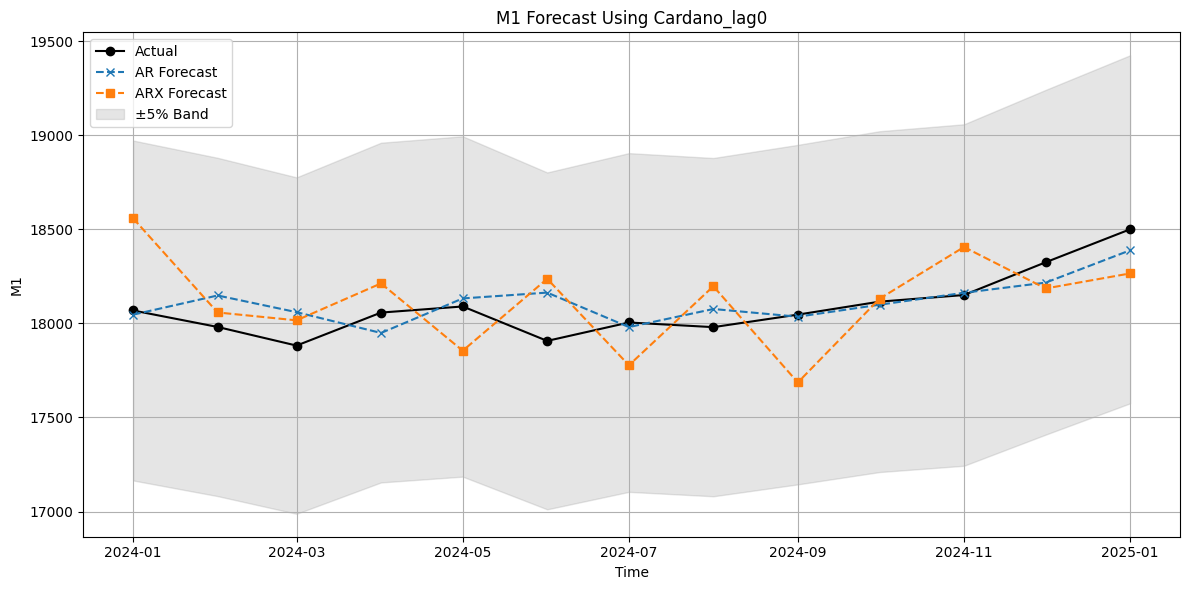

In [7]:
plot_arx_vs_ar_manual(
    index_test=df_test.index,
    actual=y_actual,
    pred_ar=pred_ar,
    pred_arx=pred_arx,
    macro_name='M1',
    title='M1 Forecast Using Cardano_lag0'
)
